In [1]:
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")
text = "The color is cyan."
encoded_input = tokenizer(text, return_tensors='pt')
print(encoded_input)
show_encode_input = tokenizer.decode(encoded_input['input_ids'][0])
print('words divided:',show_encode_input)
output = model(**encoded_input)
print('output shape',output[0].shape)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'input_ids': tensor([[  101, 10117, 14136, 10124,   171, 15976,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
words divided: [CLS] The color is cyan. [SEP]
output shape torch.Size([1, 8, 768])


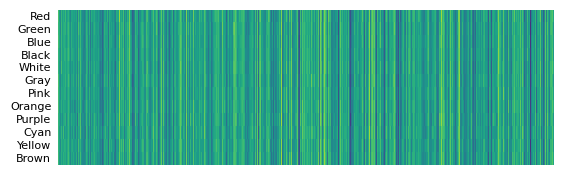

In [4]:

all_colors = ['Red',	
'Green'	,
'Blue',	
'Black'	,
'White'	,
'Gray'	,
'Pink'	,
'Orange',	
'Purple',	
'Cyan'	,
'Yellow',	
'Brown']
color_and_embeddings = {}
color_num = len(all_colors)
all_ax = []
bar_height = 20
bar_length = 768

for i,color_names in enumerate(all_colors):
    target_text = 'The color is '+color_names+'.'
    encoded_input = tokenizer(target_text, return_tensors='pt')
    output = model(**encoded_input)
    color_and_embeddings[color_names] = torch.mean(output[0][0,:,:],dim=0).cpu().detach().numpy()   # use mean pooled embedding of the sentence
    # show_encode_input = tokenizer.decode(encoded_input['input_ids'][0,4]) 
    # print('words divided:',show_encode_input)
    embeddings_to_plot = np.array([color_and_embeddings[color_names] for i in range(bar_height)])
    # print(embeddings_to_plot.shape)
    all_ax.append(embeddings_to_plot)

out_df = pd.DataFrame.from_dict(color_and_embeddings,orient='index')
out_df.reset_index().rename(columns={'index':'color'})
out_df.to_csv('basic_color_embeddings.csv')

fig, ax = plt.subplots()
ax.imshow(np.vstack(all_ax))
                     
for i, label in enumerate(all_colors):
    ax.text(-10, i * bar_height + bar_height / 2, label, va='center', ha='right', fontsize=8, color='black')
# Display the bar using Matplotlib
# plt.tight_layout()
plt.axis('off')  # Turn off axes
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

X_data = np.array(list(color_and_embeddings.values()))
cov_matrix = cosine_similarity(X_data)
# 使用 Pandas 计算的协方差矩阵
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
# 显示图形
plt.title('Cosine Similarity Matrix Heatmap')
plt.show()

MDS visualization

In [ ]:
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances,cosine_distances
from sklearn.manifold import MDS
X = np.array(list(color_and_embeddings.values()))
print(X.shape)
dist_cosine = cosine_distances(X) # 样本两两之间的距离矩阵，nxn
mds = MDS(n_components=3,dissimilarity='precomputed', random_state=0)
# Get the embeddings
X_transform_L2 = mds.fit_transform(dist_cosine)
print('MDS 降维后的嵌入点:\n',X_transform_L2)
print('stress:',mds.stress_)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plt.scatter(X_transform_L2[:,0], X_transform_L2[:,1], zs=X_transform_L2[:,2],s=64)
plt.title('MDS Points(3D)')
plt.show()